#Get relevant libraries

In [237]:
import ujson as json
import pprint
import pandas as pd
import numpy as np
import datetime
import fiona
import sklearn
import time
import datetime
import calendar
import seaborn as sns

import matplotlib.dates as mdates
from matplotlib import pyplot as plt
from ggplot import *

%matplotlib inline
pd.options.mode.chained_assignment = None  # remove default='warn'

#Import data

In [238]:
filename = "/Users/fnokeke/dev/student-streams/dataset/LocationHistory.json"

with open(filename) as json_file:
    raw = json.load(json_file)

ld = pd.DataFrame(raw['locations'])

print("Number of items in data: %d") % len(ld)

Number of items in data: 266972


#Free up memory

In [239]:
del raw

#Convert to typical units

In [240]:
ld['latitudeE7'] = ld['latitudeE7']/float(1e7)
ld['longitudeE7'] = ld['longitudeE7']/float(1e7)
ld['timestampMs'] = ld['timestampMs'].map(lambda x: float(x)/1000)
ld['datetime'] = ld.timestampMs.map(datetime.datetime.fromtimestamp)
ld['dt2'] = ld.datetime.map(lambda x: x.strftime("%Y-%m-%d %H:%M:%S"))
ld['date'] = ld.datetime.map(lambda x: x.strftime("%Y-%m-%d"))
ld['time'] = ld.datetime.map(lambda x: x.strftime("%H:%M:%S"))
ld['hr'] = ld.datetime.map(lambda x: x.strftime("%H"))
ld['min'] = ld.datetime.map(lambda x: x.strftime("%M"))

#Rename fields

In [241]:
ld.rename(columns={
'latitudeE7': 'latitude',
'longitudeE7': 'longitude',
'timestampMs': 'timestamp'
}, inplace=True)

#Understand the data types of each column

In [242]:
ld.dtypes

accuracy              int64
activitys            object
altitude            float64
heading             float64
latitude            float64
longitude           float64
timestamp           float64
velocity            float64
datetime     datetime64[ns]
dt2                  object
date                 object
time                 object
hr                   object
min                  object
dtype: object

#Get a glimpse of raw data

In [243]:
ld.head()

,accuracy,activitys,altitude,heading,latitude,longitude,timestamp,velocity,datetime,dt2,date,time,hr,min
0,20,"[{u'activities': [{u'confidence': 100, u'type'...",NaN,NaN,42.445009,-76.481233,1.444430e+09,NaN,2015-10-09 18:40:49.815,2015-10-09 18:40:49,2015-10-09,18:40:49,18,40
1,20,NaN,NaN,NaN,42.445002,-76.481257,1.444430e+09,NaN,2015-10-09 18:39:49.791,2015-10-09 18:39:49,2015-10-09,18:39:49,18,39
2,53,"[{u'activities': [{u'confidence': 100, u'type'...",NaN,NaN,42.445001,-76.481254,1.444430e+09,NaN,2015-10-09 18:38:48.981,2015-10-09 18:38:48,2015-10-09,18:38:48,18,38
3,51,"[{u'activities': [{u'confidence': 85, u'type':...",NaN,NaN,42.444977,-76.481236,1.444430e+09,NaN,2015-10-09 18:37:48.476,2015-10-09 18:37:48,2015-10-09,18:37:48,18,37
4,37,"[{u'activities': [{u'confidence': 100, u'type'...",NaN,NaN,42.444994,-76.481249,1.444430e+09,NaN,2015-10-09 18:36:59.451,2015-10-09 18:36:59,2015-10-09,18:36:59,18,36


#Get only a specific number of weeks of data from specific start date

In [244]:
no_of_weeks = 2
no_of_days = no_of_weeks * 7

start_date = ld[ld.date=='2014-11-09'].date.head(1)
start_date = pd.to_datetime(start_date)

print type(start_date)
dates = []
for i in range(no_of_days):
    x = (start_date + datetime.timedelta(days=-i)).to_string()[9:] # horrible tweak to get date in string format
    dates.append(x)
    
ld_wk = ld[ld.date.isin(dates)]
print "Week length:", len(ld_wk)
print dates[:5]

# type(pd.to_datetime("2014-11-09") + datetime.timedelta(days=-2))

<class 'pandas.core.series.Series'>
Week length: 15078
[u'2014-11-09', u'2014-11-08', u'2014-11-07', u'2014-11-06', u'2014-11-05']


#Ignore locations with accuracy estimates over 1000m

In [245]:
ld_wk = ld_wk[ld_wk.accuracy < 1000]
ld_wk.reset_index(drop=True, inplace=True)
print("Number of items in data: %d") % len(ld_wk)

Number of items in data: 14904


#Select only columns of interest

In [246]:
ld_wk = ld_wk[['latitude', 'longitude', 'datetime', 'date']]

#Specify places of interest in Ithaca and ignore locations outside Ithaca

In [247]:
home = (42.446594, -76.493736)
work = (42.444877, -76.480814)

lat_margin = 0.1
lon_margin = 1.0

ld_wk = ld_wk[abs(ld_wk.latitude - home[0]) < lat_margin]
ld_wk = ld_wk[abs(ld_wk.longitude - home[1]) < lon_margin]
print("Number of items in data: %d") % len(ld_wk)
ld_wk.head()
print "No of unique dates:", len(set(ld_wk.date))

Number of items in data: 14904
No of unique dates: 14


#Label every location as either home, work or other

In [248]:
lat_error_margin = 0.0005
lon_error_margin = 0.005

POINTS = {
    'home': home,
    'work': work
}

def get_loc_label(df, points):
    for label, point in points.items():
        within_lat = abs(df['latitude'] - point[0]) <= lat_error_margin
        within_lon = abs(df['longitude'] - point[1]) <= lon_error_margin
        if (within_lat and within_lon):
            return label
    else:
        return 'other'

ld_wk['loc_label'] = ld_wk.apply(lambda x: get_loc_label(x, POINTS), axis='columns')

#Show sample locations of home, work, other

In [249]:
rows = [0,1,59,60,61,62]
ld_wk[ld_wk['date'] == ld_wk.date[0]].iloc[rows]

,latitude,longitude,datetime,date,loc_label
0,42.449137,-76.477510,2014-11-09 23:59:18.731,2014-11-09,other
1,42.449135,-76.477484,2014-11-09 23:58:30.267,2014-11-09,other
59,42.448757,-76.477052,2014-11-09 22:42:36.146,2014-11-09,other
60,42.448759,-76.477058,2014-11-09 22:41:45.952,2014-11-09,other
61,42.448787,-76.476725,2014-11-09 22:37:19.310,2014-11-09,other
62,42.448752,-76.477033,2014-11-09 22:32:18.515,2014-11-09,other


#Resample location patterns data by different time period

In [250]:
loc_patterns = ld_wk[['datetime', 'loc_label']]
loc_patterns = loc_patterns.set_index('datetime')
loc_patterns['freq'] = 0
loc_group = loc_patterns.groupby(['loc_label']).resample('6H',how=len)
loc_group = loc_group.reset_index()
loc_group.head()

,loc_label,datetime,freq
0,home,2014-10-27 00:00:00,178
1,home,2014-10-27 06:00:00,127
2,home,2014-10-27 12:00:00,0
3,home,2014-10-27 18:00:00,0
4,home,2014-10-28 00:00:00,212


In [251]:
loc_group = loc_group.groupby(['datetime','loc_label']).sum()
loc_group.head()

freq
datetime            loc_label      
2014-10-27 00:00:00 home        178
2014-10-27 06:00:00 home        127
                    other        11
                    work         79
2014-10-27 12:00:00 home          0

In [252]:
loc_group.unstack().head()

freq           
loc_label           home other work
datetime                           
2014-10-27 00:00:00  178   NaN  NaN
2014-10-27 06:00:00  127    11   79
2014-10-27 12:00:00    0    99  197
2014-10-27 18:00:00    0     0  325
2014-10-28 00:00:00  212    21   34

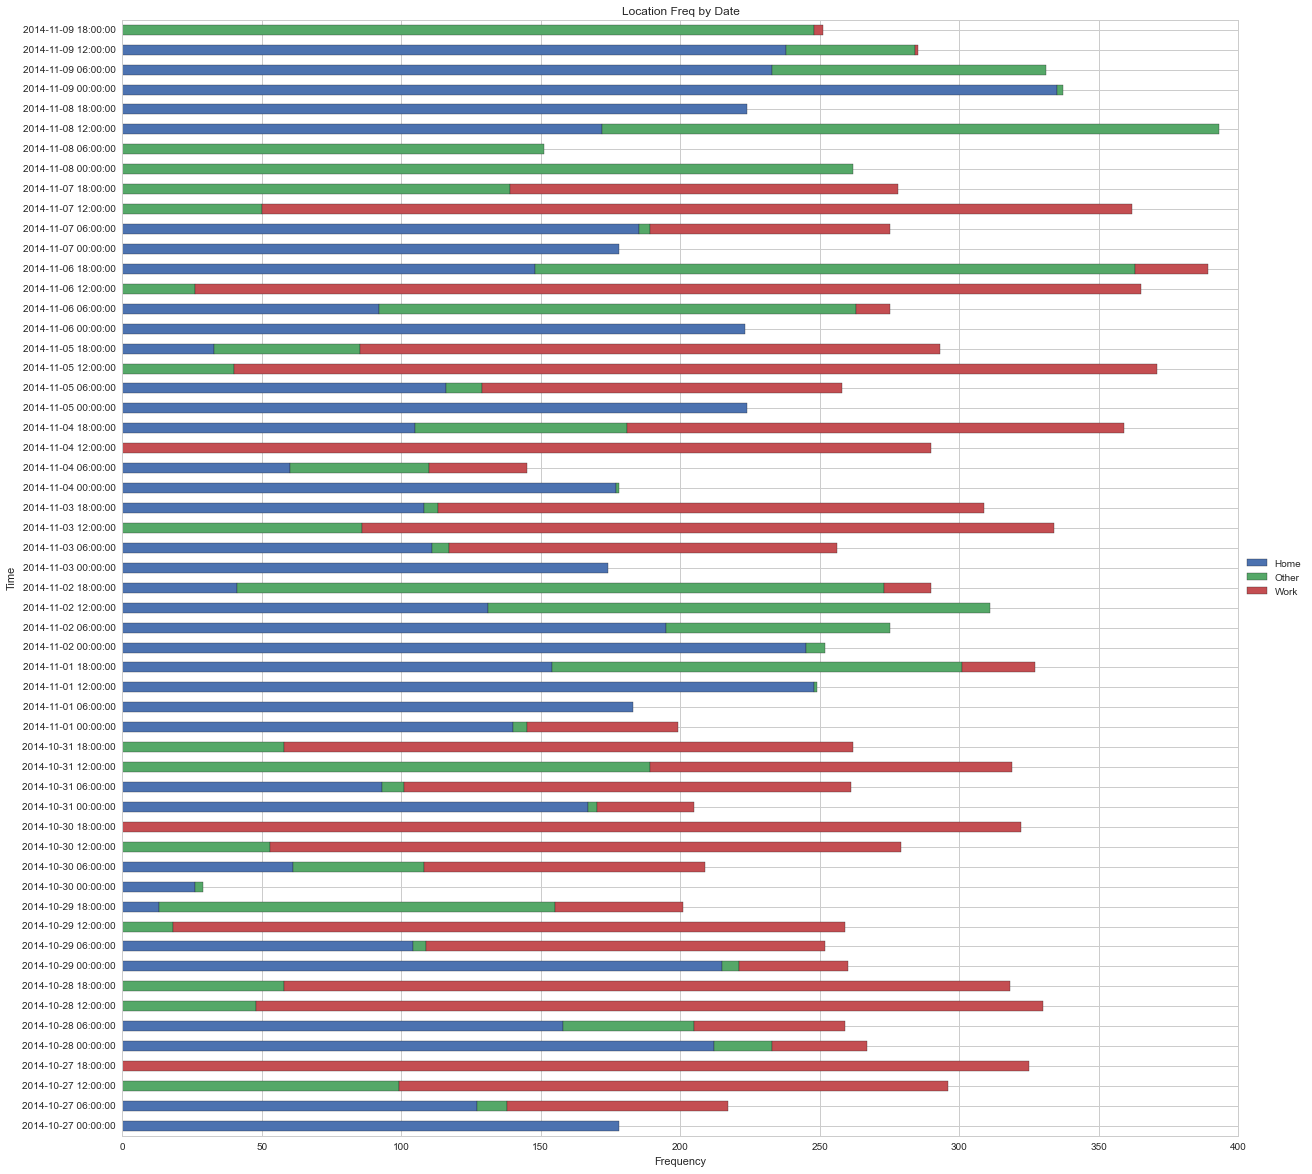

In [253]:
loc_plot = loc_group.unstack().plot(kind='barh', stacked=True, title="Location Freq by Date", figsize=(20, 20))
loc_plot.set_xlabel("Frequency")
loc_plot.set_ylabel("Time")
loc_plot.legend(["Home","Other","Work"],loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True)

#Mark every day by the day name

In [254]:
weekday_patterns = ld_wk[['datetime', 'loc_label']]
weekday_patterns['weekday'] = weekday_patterns.datetime.map(lambda x: calendar.day_name[x.weekday()])
weekday_patterns.head()

,datetime,loc_label,weekday
0,2014-11-09 23:59:18.731,other,Sunday
1,2014-11-09 23:58:30.267,other,Sunday
2,2014-11-09 23:57:37.062,other,Sunday
3,2014-11-09 23:56:46.554,other,Sunday
4,2014-11-09 23:55:56.987,other,Sunday


In [255]:
weekday_patterns['freq'] = 0
weekday_patterns = weekday_patterns.set_index('datetime')
weekday_patterns = weekday_patterns.groupby(['weekday', 'loc_label']).resample('D', how=len)
weekday_patterns.head()

freq
weekday loc_label datetime        
Friday  home      2014-10-31   260
                  2014-11-01     0
                  2014-11-02     0
                  2014-11-03     0
                  2014-11-04     0

In [256]:
shorter_df = weekday_patterns.reset_index()[['weekday', 'loc_label', 'freq']]
shorter_df.head()

,weekday,loc_label,freq
0,Friday,home,260
1,Friday,home,0
2,Friday,home,0
3,Friday,home,0
4,Friday,home,0


In [257]:
shorter_df = shorter_df.groupby(['weekday', 'loc_label']).sum().unstack()
shorter_df.head(20)

freq            
loc_label  home other  work
weekday                    
Friday      623   451  1066
Monday      698   207  1184
Saturday   1121   787    80
Sunday     1418   893    21
Thursday    550   515  1026
Tuesday     712   301  1133
Wednesday   705   276  1137

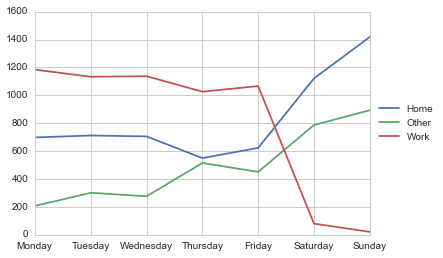

In [258]:
order_of_weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
shorter_df.index = pd.Categorical(shorter_df.index, order_of_weekdays)
shorter_df = shorter_df.sort_index()
sh_plot = shorter_df.plot()
sh_plot.legend(["Home","Other","Work"],loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True)

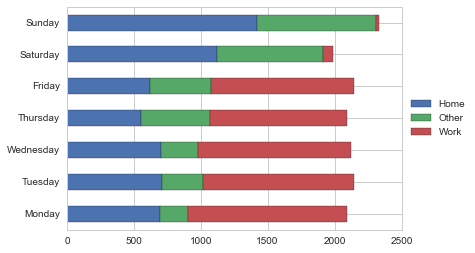

In [259]:
sh_plot = shorter_df.plot(kind='barh', stacked=True)
sh_plot.legend(["Home","Other","Work"],loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True)

#Where you are by dates

In [260]:
day_time_patterns = ld_wk[['datetime', 'loc_label']]

day_time_patterns.loc[:,'loc_label'] = pd.Categorical(day_time_patterns['loc_label'])

day_time_patterns.loc[:,'hr'] = day_time_patterns.datetime.map(lambda x: int(x.strftime("%H")) + float(x.strftime("%M"))/60)
day_time_patterns.loc[:,'hr'] = pd.Categorical(day_time_patterns['hr'])

day_time_patterns.loc[:,'weekday'] = day_time_patterns.datetime.map(lambda x: calendar.day_name[x.weekday()])
day_time_patterns.loc[:,'weekday'] = pd.Categorical(day_time_patterns['weekday'], order_of_weekdays)

day_time_patterns.head()

,datetime,loc_label,hr,weekday
0,2014-11-09 23:59:18.731,other,23.983333,Sunday
1,2014-11-09 23:58:30.267,other,23.966667,Sunday
2,2014-11-09 23:57:37.062,other,23.950000,Sunday
3,2014-11-09 23:56:46.554,other,23.933333,Sunday
4,2014-11-09 23:55:56.987,other,23.916667,Sunday


In [261]:
day_time_patterns.hr = day_time_patterns.hr.astype(float)
day_time_patterns.dtypes

datetime     datetime64[ns]
loc_label          category
hr                  float64
weekday            category
dtype: object

#Show location by time of day (seaborn plot)

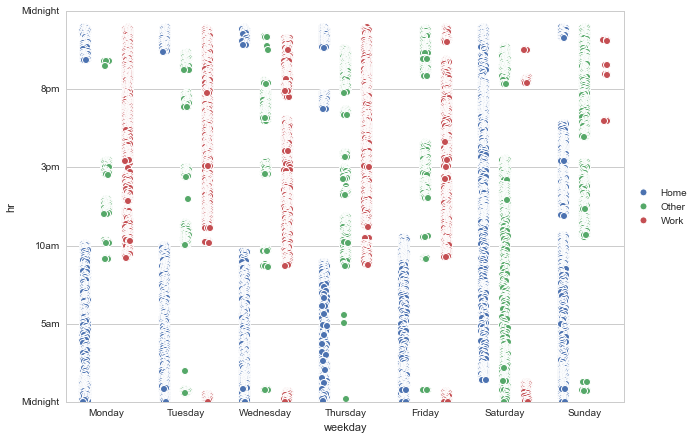

In [262]:
sns.set(style="whitegrid", color_codes=True)
sns.set_context({"figure.figsize": (10, 7)})

axes = sns.stripplot(x="weekday", y="hr", hue="loc_label", data=day_time_patterns, jitter=True);
axes.set_ylim(0,25)

labels = ["Midnight", "5am", "10am", "3pm", "8pm", "Midnight"]
axes.set_yticklabels(labels)

axes.legend(["Home","Other","Work"],loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True)

In [263]:
def get_day_num(day): 
    if day == 'Monday':
        return 1
    elif day == 'Tuesday':
        return 2    
    elif day == 'Wednesday':
        return 3    
    elif day == 'Thursday':
        return 4    
    elif day == 'Friday':
        return 5    
    elif day == 'Saturday':
        return 6    
    elif day == 'Sunday':
        return 7

day_time_patterns['day_value'] = day_time_patterns.weekday.astype(str).map(lambda x: get_day_num(x))

In [264]:
day_time_patterns.rename(columns={'loc_label': 'Location'}, inplace=True)
day_time_patterns.head(10)

,datetime,Location,hr,weekday,day_value
0,2014-11-09 23:59:18.731,other,23.983333,Sunday,7
1,2014-11-09 23:58:30.267,other,23.966667,Sunday,7
2,2014-11-09 23:57:37.062,other,23.950000,Sunday,7
3,2014-11-09 23:56:46.554,other,23.933333,Sunday,7
4,2014-11-09 23:55:56.987,other,23.916667,Sunday,7
5,2014-11-09 23:55:03.779,other,23.916667,Sunday,7
6,2014-11-09 23:54:15.421,other,23.900000,Sunday,7
7,2014-11-09 23:53:25.423,other,23.883333,Sunday,7
8,2014-11-09 23:52:34.682,other,23.866667,Sunday,7
9,2014-11-09 23:51:41.033,other,23.850000,Sunday,7


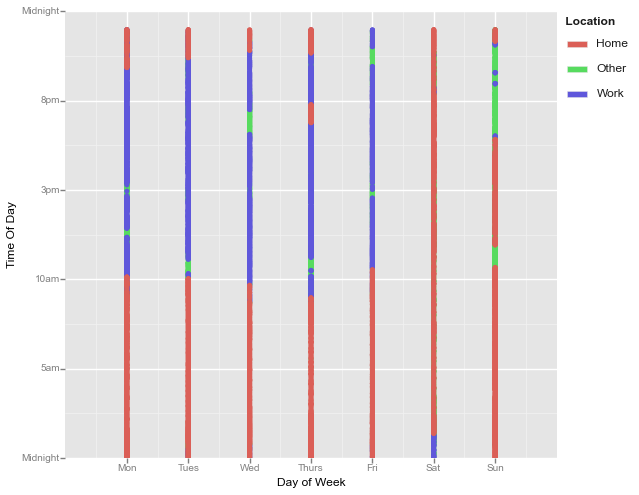

<ggplot: (366972993)>

In [265]:
weekday_label = ("Mon", "Tues", "Wed", "Thurs", "Fri", "Sat", "Sun")
time_label = ("Midnight", "5am", "10am", "3pm", "8pm", "Midnight")

ggplot(day_time_patterns, aes('day_value', 'hr', color='Location')) + \
    geom_point() + \
    scale_x_continuous(name = "Day of Week", breaks=range(1,8), labels=weekday_label) + \
    scale_y_continuous(name="Time of Day", limits=(0,25), labels=time_label)